# Experimentation notebook

In [154]:
import sys
import torch
sys.path.append('src/fast_ica')
sys.path.append('src/iVAE')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 3

from tqdm import tqdm
from sklearn.decomposition import FastICA as sk_FastICA
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

from src.iVAE.models import cleanIVAE, cleanVAE
from src.iVAE.data import CustomSyntheticDataset, SyntheticDataset, generate_data
from src.iVAE.metrics import mean_corr_coef as mcc
from src.fast_ica import FastICA

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cpu device


In [155]:
def train(
    my_model, 
    my_optimizer,
    my_scheduler,
    my_data_loader,
    eval_mixture,
    eval_sources, 
    eval_conditioning, 
    epochs, 
    device, 
    **elbo_kwargs
):
    """_summary_

    Args:
        my_model (_type_): _description_
        my_optimizer (_type_): _description_
        my_data_loader (_type_): _description_
        eval_mixture (_type_): _description_
        eval_sources (_type_): _description_
        epochs (_type_): _description_

    Returns:
        _type_: _description_
    """

    train_loss_hist = []
    train_perf_hist = []
    eval_perf_hist = []

    eval_mixture, eval_sources = eval_mixture.to(device), eval_sources.to(device)
    itterable = tqdm(range(1, epochs+1))
    for epoch in itterable:
        # Train
        my_model.train()
        train_loss = 0
        train_perf = 0
        for _, data in enumerate(my_data_loader):
            x, u, s_true = data
            x, u = x.to(device), u.to(device)
            my_optimizer.zero_grad()
            loss, s_predicted = my_model.elbo(x, u, **elbo_kwargs)
            loss.backward()
            train_loss += loss.item()
            try:
                perf = mcc(s_true.numpy(), s_predicted.cpu().detach().numpy())
            except:
                perf = 0
            train_perf += perf
            my_optimizer.step()

        train_perf /= len(my_data_loader)
        train_perf_hist.append(train_perf)
        train_loss /= len(my_data_loader)
        train_loss_hist.append(train_loss)

        # Evaluate
        my_model.eval()
        _, _, _, s, _ = my_model(eval_mixture, eval_conditioning)
        try:
            eval_perf = mcc(eval_sources.numpy(), s.cpu().detach().numpy())
        except:
            eval_perf = 0
        eval_perf_hist.append(eval_perf)

        itterable.set_description(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.2f} | Train Perf: {train_perf:.2f} | Eval Perf: {eval_perf:.2f}")

        my_scheduler.step(train_loss)

    return train_loss_hist, train_perf_hist, eval_perf_hist


## Parameters

In [156]:
# number_of_points_by_segment = 1000
# number_of_segments = 5
# dimension_of_latent_space = 2
# dimension_of_data_space = 2
# seed = 1
# prior = 'gauss'

# simple_mixing = False 
# linear_transformation_type="uniform"
# activation = 'xtanh' # if simple_mixing is True, activation is not used
# slope = 0.1 # if simple_mixing is True, slope is not used
# number_of_mixing_layers = 6 # if simple_mixing is True, number_of_mixing_layers is not used
# repeat_linearity = True # if simple_mixing is True, repeat_linearity is not used

# uncentered = True
# # centers = np.random.uniform(-15, 15, (number_of_segments, dimension_of_data_space))
# centers = np.array([[-5,6], [0,0], [0,-4], [1,2], [6,0 ]])

# var_bounds = np.array([0.5, 3])

# noisy = 0.01
# staircase = False

In [179]:
number_of_points_by_segment = 100
number_of_segments = 7
dimension_of_latent_space = 2
dimension_of_data_space = 2
seed = 1
prior = 'lap'

simple_mixing = False 
linear_transformation_type="uniform"
activation = 'xtanh' # if simple_mixing is True, activation is not used
slope = 0.1 # if simple_mixing is True, slope is not used
number_of_mixing_layers = 3 # if simple_mixing is True, number_of_mixing_layers is not used
repeat_linearity = False # if simple_mixing is True, repeat_linearity is not used

uncentered = True
centers = None

var_bounds = np.array([0.5, 3])

noisy = 0
staircase = False

In [180]:
number_of_simulation = 1
vae_hidden_dim = 100
vae_n_layers = 3
vae_activation = 'lrelu'
vae_slope = 0.1

# Learning rate scheduler params
lr = 0.01
factor = 0.1
patience = 0
verbose = True

epochs = 50

# ELBO weights
a = 100 # reconstruction log-likelihood term
b = 1 #  KL divergence between the approximate posterior an implicit mixture distribution
c = 0 # difference between the log probabilities under the implicit mixture distribution and an importance-sampled approximation
d = 10 # KL divergence between the importance-sampled approximation of the log probabilities under the variational posterior and the prior

## Data

### Generation

In [181]:
dataset = SyntheticDataset(
    "./", 
    number_of_points_by_segment, 
    number_of_segments, 
    dimension_of_latent_space, 
    dimension_of_data_space, 
    number_of_mixing_layers, 
    seed, 
    prior,
    activation, 
    uncentered, 
    noisy, 
    one_hot_labels=True, 
    simple_mixing=simple_mixing,
    centers=centers,
)
source, mixture, segment_labels = dataset.s, dataset.x, dataset.u
indices = np.argmax(segment_labels, axis=1)

Creating dataset ./tcl_100_7_2_2_3_1_lap_xtanh_u_one_hot.npz ...
 ... done
loading data from ./tcl_100_7_2_2_3_1_lap_xtanh_u_one_hot.npz


In [182]:
df = pd.concat([
    pd.DataFrame(source, columns=[f"s_{i}" for i in range(source.shape[1])]),
    pd.DataFrame(mixture, columns=[f"x_{i}" for i in range(mixture.shape[1])]),
    pd.DataFrame(indices, columns=["segment"])
], axis=1)

### Visualization

In [183]:
# sns.pairplot(df, hue="segment", palette=f"tab10")

Text(0.5, 1.0, 'Original sources')

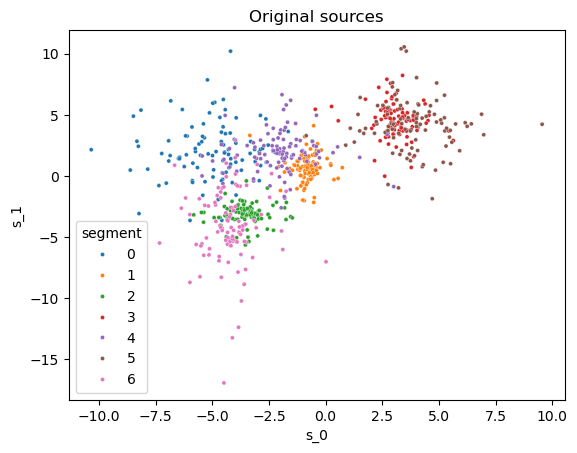

In [184]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Mixed sources')

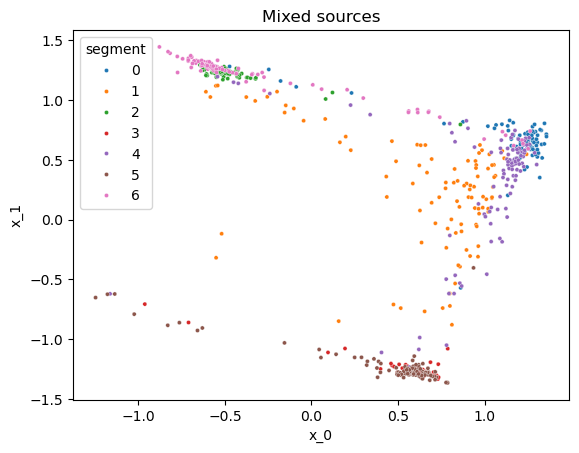

In [185]:
sns.scatterplot(data=df, x="x_0", y="x_1", hue="segment", palette="tab10")
plt.title("Mixed sources")

In [186]:
# # plot signals
# fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
# for i in range(source.shape[1]):
#     axs[i].plot(source[:, i])
#     axs[i].set_title(f"Source {i}")

In [187]:
# fig, axs = plt.subplots(mixture.shape[1], 1, figsize=(10, 5))
# for i in range(mixture.shape[1]):
#     axs[i].plot(mixture[:, i])
#     axs[i].set_title(f"Mixture {i}")

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_18455/2533683248.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


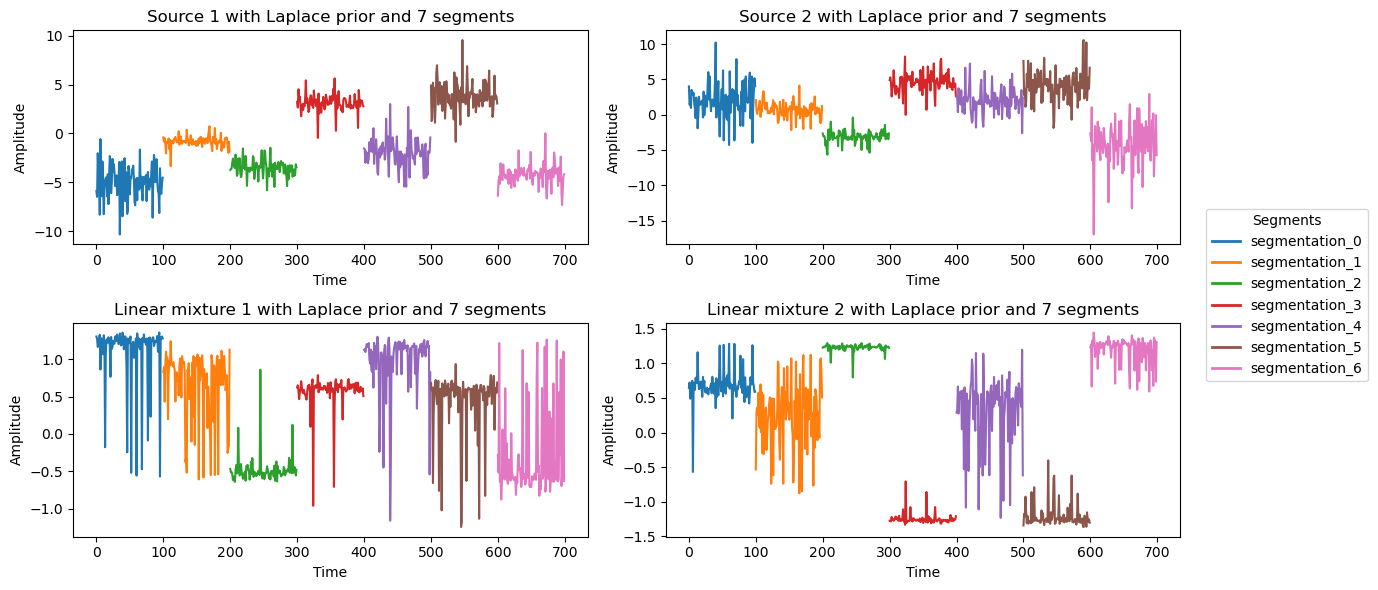

In [189]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Simuler des données pour les tests
number_of_segments = 7
number_of_points_by_segment = 100

# Couleurs pour les segments
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']
colors = plt.cm.get_cmap('tab10') 

# Créer les graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Source 1
axes[0, 0].set_title("Source 1 with Laplace prior and 7 segments")
for seg in range(number_of_segments):
    axes[0, 0].plot(
        range(seg * number_of_points_by_segment, (seg + 1) * number_of_points_by_segment),
        source[seg * number_of_points_by_segment:(seg + 1) * number_of_points_by_segment, 0],
        color=colors(seg)
    )
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")

# Source 2
axes[0, 1].set_title("Source 2 with Laplace prior and 7 segments")
for seg in range(number_of_segments):
    axes[0, 1].plot(
        range(seg * number_of_points_by_segment, (seg + 1) * number_of_points_by_segment),
        source[seg * number_of_points_by_segment:(seg + 1) * number_of_points_by_segment, 1],
        color=colors(seg)
    )
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Amplitude")

# Mixed 1
axes[1, 0].set_title("Linear mixture 1 with Laplace prior and 7 segments")
for seg in range(number_of_segments):
    axes[1, 0].plot(
        range(seg * number_of_points_by_segment, (seg + 1) * number_of_points_by_segment),
        mixture[seg * number_of_points_by_segment:(seg + 1) * number_of_points_by_segment, 0],
        color=colors(seg)
    )
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Amplitude")

# Mixed 2
axes[1, 1].set_title("Linear mixture 2 with Laplace prior and 7 segments")
for seg in range(number_of_segments):
    axes[1, 1].plot(
        range(seg * number_of_points_by_segment, (seg + 1) * number_of_points_by_segment),
        mixture[seg * number_of_points_by_segment:(seg + 1) * number_of_points_by_segment, 1],
        color=colors(seg)
    )
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Amplitude")

# Ajouter une légende unique sur le côté droit
legend_elements = [
    Line2D([0], [0], color=colors(i), lw=2, label=f'segmentation_{i}') for i in range(number_of_segments)
]
fig.legend(handles=legend_elements, loc='center right', title="Segments", bbox_to_anchor=(1.15, 0.5))

# Ajuster l'espacement pour que tout s'affiche correctement
plt.tight_layout()  # Laisser de l'espace pour la légende sur le côté droit

plt.savefig("non_linear_mixing_sources_examples.pdf")


In [148]:
mixture_np = mixture.numpy()
mixture_np.shape

(500, 2)

## FastICA

In [149]:
ica = FastICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=10000)
fast_ica_source_predict = ica.fit_transform(mixture, method='parallel')

In [150]:
ica = FastICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=10000)

In [151]:
df_fast_ica = pd.concat([
  df,
  pd.DataFrame(fast_ica_source_predict, columns=[f"fast_ica_s_{i}" for i in range(fast_ica_source_predict.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'Original sources')

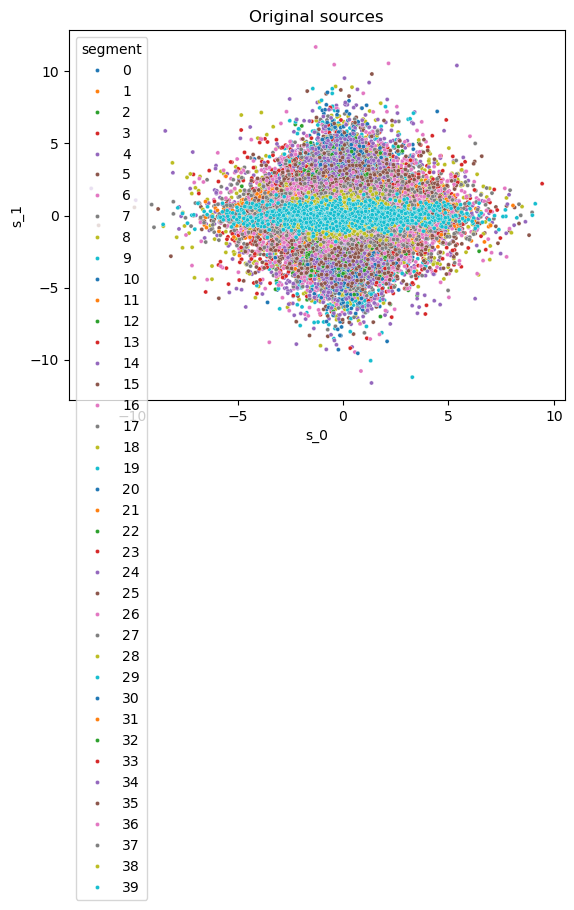

In [17]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Fast ICA recovered sources')

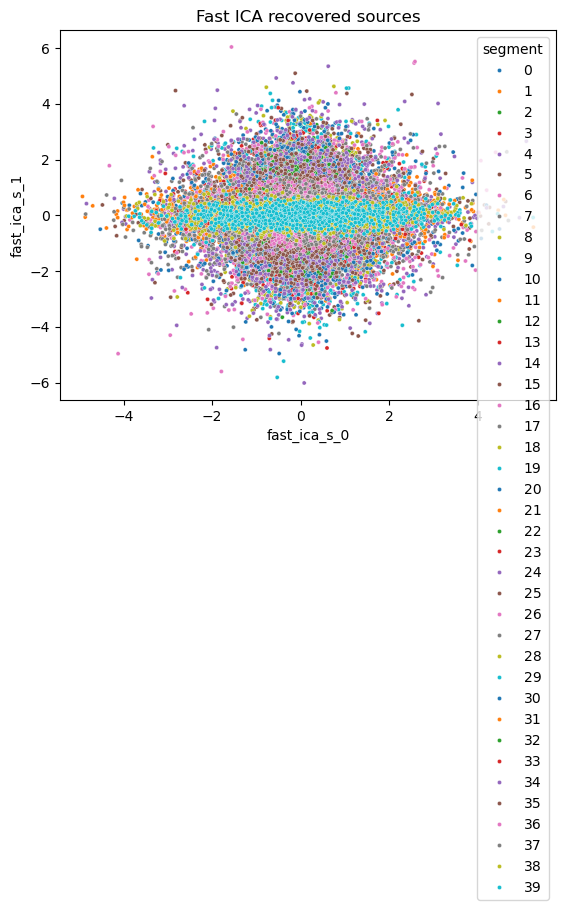

In [18]:
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10")
plt.title("Fast ICA recovered sources")

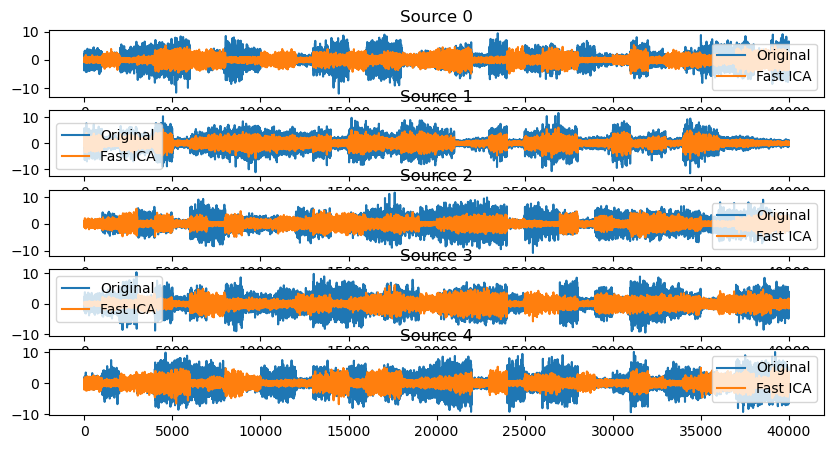

In [19]:
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    axs[i].plot(source[:, i], label="Original")
    axs[i].plot(fast_ica_source_predict[:, i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

In [20]:
# sns.pairplot(df_fast_ica, hue="segment", palette=f"tab10")

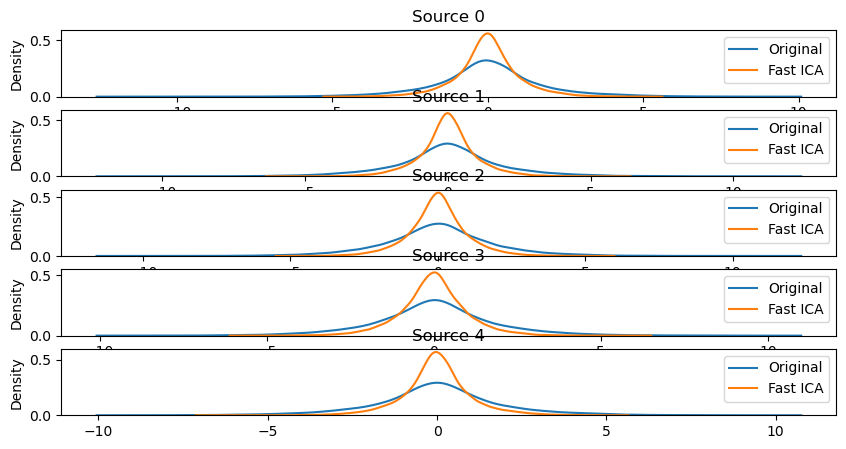

In [21]:
# plot distibution
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    sns.kdeplot(source[:, i], ax=axs[i], label="Original")
    sns.kdeplot(fast_ica_source_predict[:, i], ax=axs[i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

In [22]:
mcc(source.numpy(), fast_ica_source_predict)

0.9997231197875596

## VAE

In [55]:
loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    **loader_params
)

In [56]:
d_data, d_latent, d_aux = dataset.get_dims()
vae_model = cleanVAE(
    data_dim=d_data,
    latent_dim=d_latent,
    hidden_dim=vae_hidden_dim,
    n_layers=vae_n_layers,
    activation=vae_activation,
    slope=0.1,
).to(device)

optimizer = Adam(vae_model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=0, verbose=True
)

/Users/sullivancastro/miniforge3/envs/altegrad-lab4/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [57]:
vae_loss_hist, vae_perf_hist, vae_all_mccs = train(
    vae_model,
    optimizer,
    scheduler,
    data_loader,
    dataset.x,
    dataset.s,
    dataset.u,
    20,
    device,
    N=len(dataset),
    a=100,
    b=1,
    c=0,
    d=10,
)


Epoch 20/20 | Train Loss: -600.36 | Train Perf: 0.63 | Eval Perf: 0.66: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


Text(0.5, 1.0, 'Eval perf')

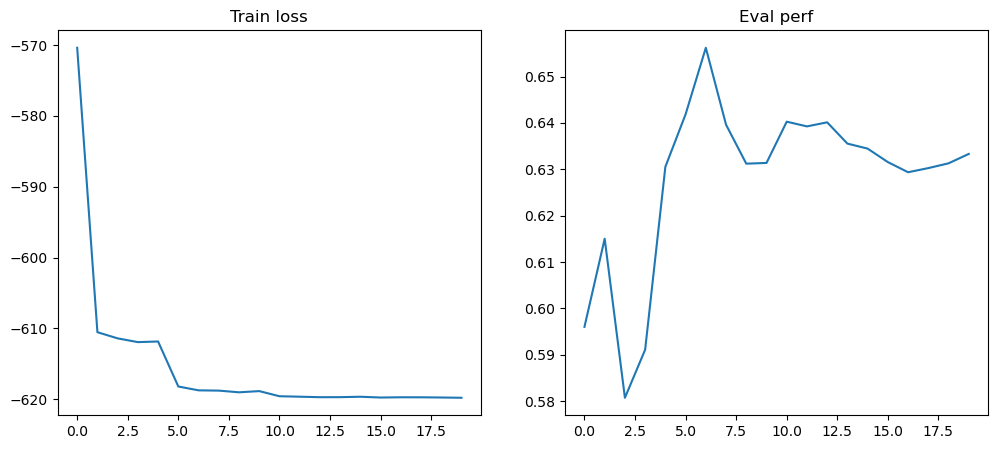

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax[0].plot(vae_loss_hist)
ax[0].set_title("Train loss")
ax[1].plot(vae_perf_hist)
ax[1].set_title("Eval perf")

In [28]:
vae_model.eval()
_, _, _, s_predicted, _ = vae_model(dataset.x.to(device))
s_predicted = s_predicted.cpu().detach().numpy()

In [29]:
vae_df = pd.concat([
    df,
    pd.DataFrame(s_predicted, columns=[f"vae_s_{i}" for i in range(s_predicted.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'VAE recovered sources')

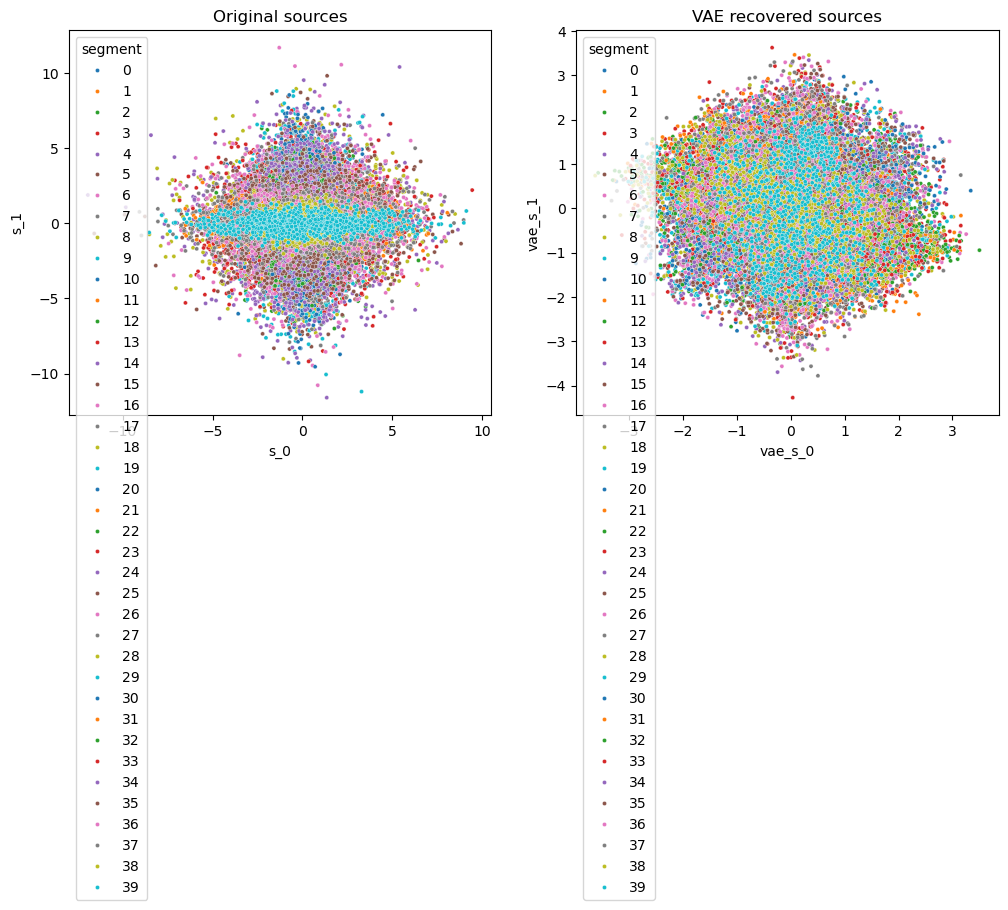

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
sns.scatterplot(data=vae_df, x="vae_s_0", y="vae_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("VAE recovered sources")

## IVAE

In [31]:
loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    **loader_params
)

In [32]:
ivae_model = cleanIVAE(
    data_dim=dimension_of_data_space,
    latent_dim=dimension_of_latent_space,
    hidden_dim=vae_hidden_dim,
    aux_dim=number_of_segments,
    n_layers=vae_n_layers,
    activation=vae_activation,
    slope=vae_slope,
).to(device)

optimizer = Adam(ivae_model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=0, verbose=True
)

/Users/sullivancastro/miniforge3/envs/altegrad-lab4/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
ivae_loss_hist, ivae_perf_hist, ivae_all_mccs = train(
    ivae_model,
    optimizer,
    scheduler,
    data_loader,
    mixture,
    source,
    segment_labels,
    20,
    device,
    N=len(dataset),
    a=100,
    b=1,
    c=0,
    d=10,
)


Epoch 20/20 | Train Loss: -625.57 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Text(0.5, 1.0, 'Eval perf')

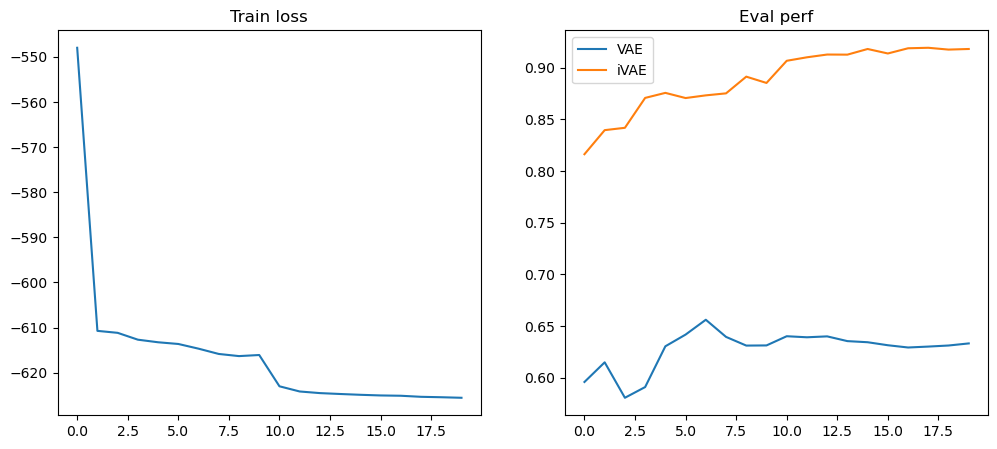

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax[0].plot(ivae_loss_hist)
ax[0].set_title("Train loss")
ax[1].plot(vae_perf_hist, label="VAE")
ax[1].plot(ivae_all_mccs, label="iVAE")
ax[1].legend()
ax[1].set_title("Eval perf")

In [35]:
ivae_model.eval()
_, _, _, s_predicted, _ = ivae_model(dataset.x.to(device), dataset.u.to(device))
s_predicted = s_predicted.cpu().detach().numpy()

In [36]:
ivae_df = pd.concat([
    df,
    pd.DataFrame(s_predicted, columns=[f"ivae_s_{i}" for i in range(s_predicted.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'iVAE recovered sources')

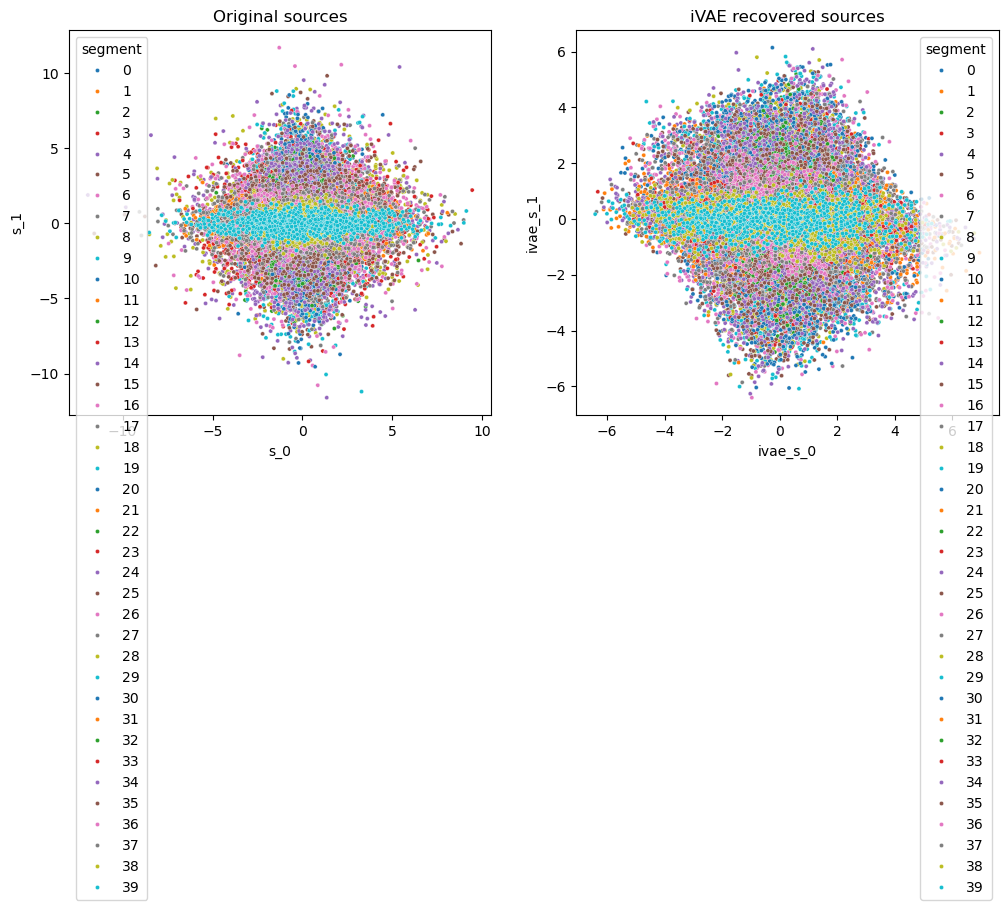

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
sns.scatterplot(data=ivae_df, x="ivae_s_0", y="ivae_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("iVAE recovered sources")

# Sully's Experiment

In [35]:
import os
num_sim = 10
nb_epochs = 20

loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)

hist_mcc = np.zeros((6, num_sim, nb_epochs))
hist_dict = {
    0: "VAE linear",
    1: "iVAE linear",
    2: "FastICA linear",
    3: "VAE non linear",
    4: "iVAE non linear",
    5: "FastICA non linear"
}

for k, name in hist_dict.items():
    for n_sim in range(num_sim):

        if "non linear" in name:
            dataset = SyntheticDataset(
                "./", 
                number_of_points_by_segment, 
                number_of_segments, 
                dimension_of_latent_space, 
                dimension_of_data_space, 
                number_of_mixing_layers, 
                seed, 
                prior,
                activation, 
                uncentered, 
                noisy, 
                one_hot_labels=True, 
                simple_mixing=False,
                centers=centers,
            )
        else:
            dataset = SyntheticDataset(
                "./", 
                number_of_points_by_segment, 
                number_of_segments, 
                dimension_of_latent_space, 
                dimension_of_data_space, 
                number_of_mixing_layers, 
                seed, 
                prior,
                activation, 
                uncentered, 
                noisy, 
                one_hot_labels=True, 
                simple_mixing=True,
                centers=centers,
            )
        source, mixture, segment_labels = dataset.s, dataset.x, dataset.u
        d_data, d_latent, d_aux = dataset.get_dims()

        data_loader = DataLoader(
            dataset,
            batch_size=64,
            shuffle=True,
            drop_last=False,
            **loader_params
            )
        
        if k%3 == 0:
            print(f"Training {name} model - iteration {n_sim}")
            model = cleanVAE(
                data_dim=d_data,
                latent_dim=d_latent,
                hidden_dim=vae_hidden_dim,
                n_layers=vae_n_layers,
                activation=vae_activation,
                slope=0.1,
            ).to(device)
            

        elif k%3 == 1:
            print(f"Training {name} model - iteration {n_sim}")
            model = cleanIVAE(
                data_dim=dimension_of_data_space,
                latent_dim=dimension_of_latent_space,
                hidden_dim=vae_hidden_dim,
                aux_dim=number_of_segments,
                n_layers=vae_n_layers,
                activation=vae_activation,
                slope=vae_slope,
            ).to(device)
            

        optimizer = Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=0.1, patience=0, verbose=True
        )

        if k%3 != 2:
            _, _, all_mccs = train(
                model,
                optimizer,
                scheduler,
                data_loader,
                dataset.x,
                dataset.s,
                dataset.u,
                nb_epochs,
                device,
                N=len(dataset),
                a=100,
                b=1,
                c=0,
                d=10,
            )
            hist_mcc[k, n_sim, :] = all_mccs

        else:
            print(f"Training {name} model - iteration {n_sim}")
            ica = FastICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=nb_epochs)
            _, ica_all_mccs = ica.fit_transform(mixture, method='parallel', source=source)
            hist_mcc[k, n_sim, :] = np.pad(ica_all_mccs, pad_width=(0, nb_epochs-ica_all_mccs.shape[0]), mode='constant', constant_values=ica_all_mccs[-1])
        
        print('\n')
        os.remove('/Users/sullivancastro/Desktop/MVA/Probabilist Graphical Model and Deep Generative Model/Independent-Component-Analysis/tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz')

/Users/sullivancastro/miniforge3/envs/altegrad-lab4/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 0


Epoch 20/20 | Train Loss: -619.41 | Train Perf: 0.70 | Eval Perf: 0.69: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 1


Epoch 20/20 | Train Loss: -602.37 | Train Perf: 0.65 | Eval Perf: 0.65: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 2


Epoch 20/20 | Train Loss: -600.86 | Train Perf: 0.60 | Eval Perf: 0.57: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 3


Epoch 20/20 | Train Loss: -600.86 | Train Perf: 0.76 | Eval Perf: 0.76: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 4


Epoch 20/20 | Train Loss: -601.52 | Train Perf: 0.62 | Eval Perf: 0.60: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 5


Epoch 20/20 | Train Loss: -600.51 | Train Perf: 0.63 | Eval Perf: 0.62: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 6


Epoch 20/20 | Train Loss: -599.81 | Train Perf: 0.65 | Eval Perf: 0.65: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 7


Epoch 20/20 | Train Loss: -601.16 | Train Perf: 0.63 | Eval Perf: 0.62: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 8


Epoch 20/20 | Train Loss: -600.87 | Train Perf: 0.64 | Eval Perf: 0.63: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE linear model - iteration 9


Epoch 20/20 | Train Loss: -600.46 | Train Perf: 0.70 | Eval Perf: 0.70: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 0


Epoch 20/20 | Train Loss: -606.49 | Train Perf: 0.83 | Eval Perf: 0.83: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 1


Epoch 20/20 | Train Loss: -605.73 | Train Perf: 0.86 | Eval Perf: 0.86: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 2


Epoch 20/20 | Train Loss: -603.83 | Train Perf: 0.69 | Eval Perf: 0.68: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 3


Epoch 20/20 | Train Loss: -605.70 | Train Perf: 0.86 | Eval Perf: 0.86: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 4


Epoch 20/20 | Train Loss: -607.67 | Train Perf: 0.94 | Eval Perf: 0.94: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 5


Epoch 20/20 | Train Loss: -604.70 | Train Perf: 0.83 | Eval Perf: 0.83: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 6


Epoch 20/20 | Train Loss: nan | Train Perf: 0.00 | Eval Perf: 0.00: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 7


Epoch 20/20 | Train Loss: -606.28 | Train Perf: 0.84 | Eval Perf: 0.84: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 8


Epoch 20/20 | Train Loss: -605.19 | Train Perf: 0.84 | Eval Perf: 0.84: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE linear model - iteration 9


Epoch 20/20 | Train Loss: -604.52 | Train Perf: 0.73 | Eval Perf: 0.73: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA linear model - iteration 0


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA linear model - iteration 1


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA linear model - iteration 2


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA linear model - iteration 3


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA linear model - iteration 4


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz 

Epoch 20/20 | Train Loss: -620.22 | Train Perf: 0.58 | Eval Perf: 0.56: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 1


Epoch 20/20 | Train Loss: -619.54 | Train Perf: 0.64 | Eval Perf: 0.63: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 2


Epoch 20/20 | Train Loss: -619.53 | Train Perf: 0.62 | Eval Perf: 0.60: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 3


Epoch 20/20 | Train Loss: -619.46 | Train Perf: 0.61 | Eval Perf: 0.60: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 4


Epoch 20/20 | Train Loss: -619.23 | Train Perf: 0.64 | Eval Perf: 0.62: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 5


Epoch 20/20 | Train Loss: -619.39 | Train Perf: 0.75 | Eval Perf: 0.76: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 6


Epoch 20/20 | Train Loss: -619.84 | Train Perf: 0.65 | Eval Perf: 0.65: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 7


Epoch 20/20 | Train Loss: -619.79 | Train Perf: 0.65 | Eval Perf: 0.65: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 8


Epoch 20/20 | Train Loss: -619.31 | Train Perf: 0.68 | Eval Perf: 0.68: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training VAE non linear model - iteration 9


Epoch 20/20 | Train Loss: -619.93 | Train Perf: 0.72 | Eval Perf: 0.72: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 0


Epoch 20/20 | Train Loss: -625.37 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 1


Epoch 20/20 | Train Loss: -625.72 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 2


Epoch 20/20 | Train Loss: -624.81 | Train Perf: 0.91 | Eval Perf: 0.91: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 3


Epoch 20/20 | Train Loss: -624.88 | Train Perf: 0.91 | Eval Perf: 0.91: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 4


Epoch 20/20 | Train Loss: -625.65 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 5


Epoch 20/20 | Train Loss: -625.70 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 6


Epoch 20/20 | Train Loss: -625.55 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 7


Epoch 20/20 | Train Loss: -625.11 | Train Perf: 0.91 | Eval Perf: 0.91: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 8


Epoch 20/20 | Train Loss: -625.61 | Train Perf: 0.92 | Eval Perf: 0.92: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training iVAE non linear model - iteration 9


Epoch 20/20 | Train Loss: -625.12 | Train Perf: 0.92 | Eval Perf: 0.91: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]




Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA non linear model - iteration 0


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA non linear model - iteration 1


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA non linear model - iteration 2


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA non linear model - iteration 3


Creating dataset ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz ...
 ... done
loading data from ./tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz
Training FastICA non linear model - iteration 4


Creating dataset ./tcl_1000_40_5_5_3_1_gaus

In [37]:
hist_mcc

array([[[0.65909425, 0.67835057, 0.64270257, ..., 0.71575959,
         0.70223087, 0.68727022],
        [0.77624988, 0.71980133, 0.70559236, ..., 0.64863938,
         0.64780666, 0.64826624],
        [0.60271054, 0.61283295, 0.59318547, ..., 0.57761288,
         0.57944367, 0.57289187],
        ...,
        [0.69668218, 0.68165301, 0.67629355, ..., 0.61997198,
         0.62001973, 0.62000762],
        [0.74525145, 0.6706378 , 0.67939601, ..., 0.63041039,
         0.63063941, 0.63007888],
        [0.7131034 , 0.67767861, 0.70187791, ..., 0.70162483,
         0.70209243, 0.70131623]],

       [[0.65661331, 0.77327486, 0.79481003, ..., 0.82801053,
         0.83016579, 0.83026785],
        [0.71791107, 0.74936444, 0.78256991, ..., 0.85725047,
         0.85838762, 0.85703681],
        [0.71059105, 0.70393259, 0.67891403, ..., 0.67714656,
         0.67995647, 0.68069141],
        ...,
        [0.72154883, 0.73441876, 0.75310275, ..., 0.83886075,
         0.84054796, 0.84076383],
        [0.6

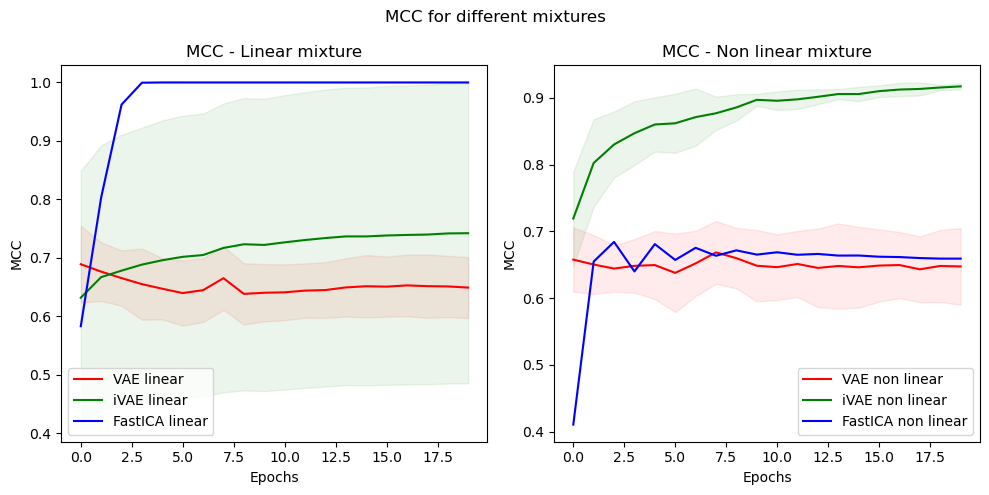

In [90]:
plt.figure(figsize=(10, 5))
colors = [
    "r",
    "g",
    "b",
]

plt.subplot(1, 2, 1)
plt.title("MCC - Linear mixture")
for k, name in hist_dict.items():
    if "non linear" not in name:
        plt.plot(hist_mcc[k].mean(axis=0), label=name, color=colors[k])
        plt.fill_between(
            range(nb_epochs),
            hist_mcc[k].mean(axis=0) - hist_mcc[k].std(axis=0),
            hist_mcc[k].mean(axis=0) + hist_mcc[k].std(axis=0),
            color=colors[k],
            alpha=0.08
        )
plt.xlabel("Epochs")
plt.ylabel("MCC")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("MCC - Non linear mixture")
for k, name in hist_dict.items():

    if "non linear" in name:
        plt.plot(hist_mcc[k].mean(axis=0), label=name, color=colors[k%3])
        plt.fill_between(
            range(nb_epochs),
            hist_mcc[k].mean(axis=0) - hist_mcc[k].std(axis=0),
            hist_mcc[k].mean(axis=0) + hist_mcc[k].std(axis=0),
            color=colors[k%3],
            alpha=0.08
        )
plt.xlabel("Epochs")
plt.ylabel("MCC")
plt.legend()

plt.suptitle("MCC for different mixtures")
plt.tight_layout()
plt.show()

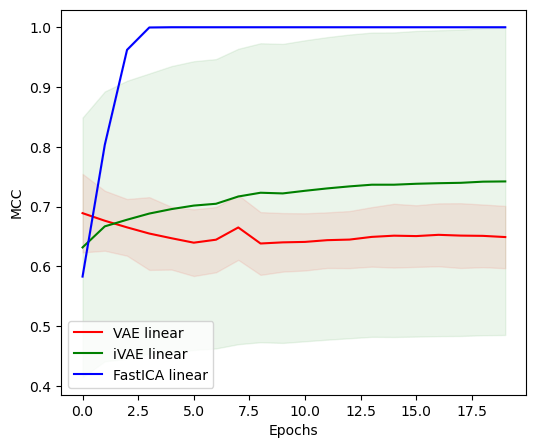

In [102]:
plt.figure(figsize=(6, 5))
for k, name in hist_dict.items():
    if "non linear" not in name:
        plt.plot(hist_mcc[k].mean(axis=0), label=name, color=colors[k])
        plt.fill_between(
            range(nb_epochs),
            hist_mcc[k].mean(axis=0) - hist_mcc[k].std(axis=0),
            hist_mcc[k].mean(axis=0) + hist_mcc[k].std(axis=0),
            color=colors[k],
            alpha=0.08
        )
plt.xlabel("Epochs")
plt.ylabel("MCC")
plt.legend()
plt.savefig("mcc_linear.pdf")

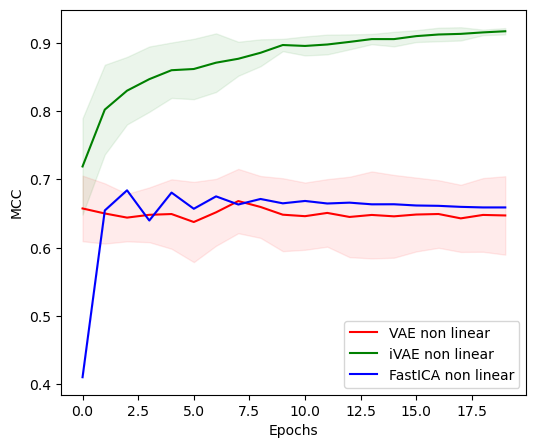

In [101]:
plt.figure(figsize=(6, 5))
for k, name in hist_dict.items():

    if "non linear" in name:
        plt.plot(hist_mcc[k].mean(axis=0), label=name, color=colors[k%3])
        plt.fill_between(
            range(nb_epochs),
            hist_mcc[k].mean(axis=0) - hist_mcc[k].std(axis=0),
            hist_mcc[k].mean(axis=0) + hist_mcc[k].std(axis=0),
            color=colors[k%3],
            alpha=0.08
        )
plt.xlabel("Epochs")
plt.ylabel("MCC")
plt.legend()
plt.savefig("mcc_non_linear.pdf")